In [1]:
import pathlib
import pandas as pd
import tarfile
import urllib.request
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Params

In [3]:
datasets = pathlib.Path().cwd().parents[2] / 'data/sample-data'
random_state, seed  = 42, 42


In [4]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = datasets / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Get Data

In [6]:
def load_housing_data():
    tarball_path = datasets / "housing.tgz"
    if not tarball_path.is_file():
        datasets.mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv( 'datasets/housing/housing.csv')

df = load_housing_data()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


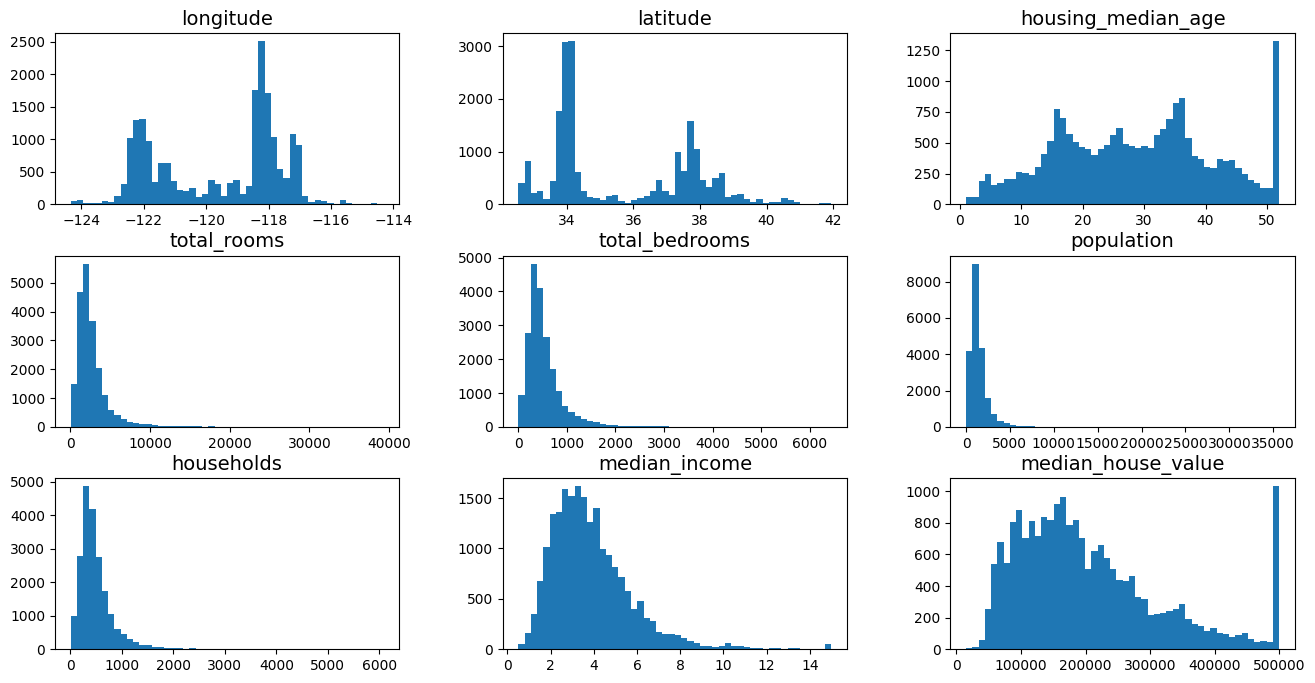

In [9]:
df.hist(bins=50, figsize=(16, 8), grid = False)
# save_fig("attribute_histogram_plots")  # extra code

plt.show()

In [10]:
df.shape

(20640, 10)

In [11]:
def shuffle_and_split_data(data, split_ratio= .2):
    np.random.seed(42)
    indicies = np.random.permutation(len(data))
    split = int(len(data) * split_ratio)
    train = indicies[:split]
    test = indicies[split:]
    train_set = data.iloc[train]
    test_set = data.iloc[test]
    return train_set, test_set

In [12]:
train_set, test_set = shuffle_and_split_data(df)
train_set, test_set = train_test_split(df,test_size=0.2, shuffle=True, random_state=42)

This Split will not generate the same set of test and train split if new data is added to the Dataset. For the effectiveness of the model, we need to provide the same set of training data and we shouldnt expose the model to the test data. This is very crucial for the validating the model generalisation.

- Sklearn train_test_split will set the random seed and will remember the Train and Test data. 

In [13]:
from zlib import crc32

In [14]:
df_id = df.copy()

In [15]:
df_id['id'] = ((df_id['longitude'] * 1000) + df_id['latitude']* 1000 + (df_id['median_income'] * 1000 + df_id['households']))

In [16]:
df_id['id'] = pd.util.hash_pandas_object(df_id)

In [17]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

We can generate the hash key for each record and use these id's for train_test_split. 

Pandas has a utility to generate the hash values. However, if the data is shuffled then the hash ids will be modified. So, as long as the sequence of the data is not modified this might work but this is not guranteed in the real scenarios. 

Since our data has stratified classes with different proportions so we would like to have a proper sampling to reflect the stratified classes in our test and train data. 

sklearn has the stratifiedtesttrain split.

In [18]:
df_id.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'id'],
      dtype='object')

# Generate the Income Categories

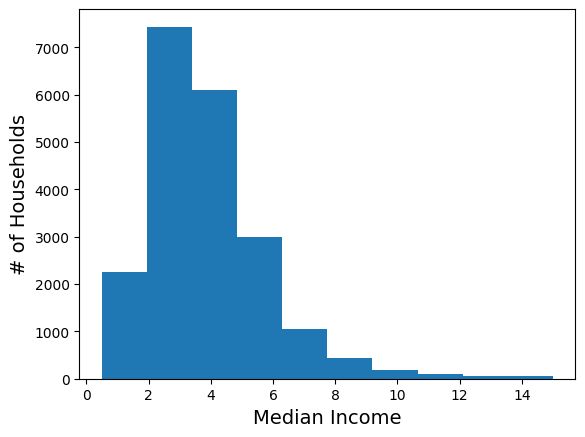

In [19]:
df.median_income.plot(kind='hist')
plt.xlabel('Median Income')
plt.ylabel('# of Households')
plt.show()

In [20]:
income_bins = [i * 1.5 if i > 0 else i for i in range(5)]

In [21]:
df['income_cat'] = pd.cut(df.median_income, bins=[*income_bins, np.inf],labels=income_bins)

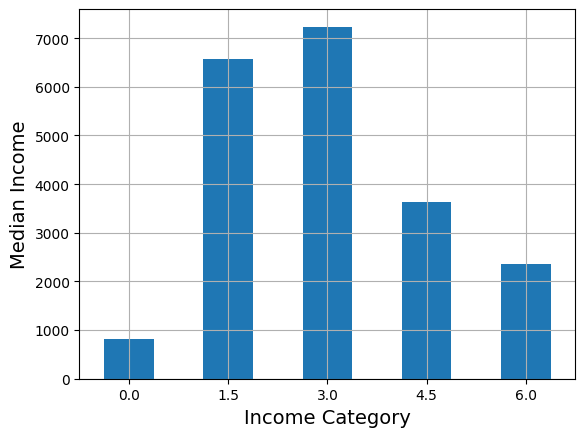

In [22]:
df['income_cat'].value_counts().sort_index().plot.bar(rot= 0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Median Income")
plt.show()

In [23]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=random_state)

In [24]:
strat_train_set, strat_test_set = train_test_split(df,test_size=0.2,random_state=random_state, stratify=df['income_cat'])

In [25]:
train_test_split_summary = pd.DataFrame({
    'overall': df.income_cat.value_counts().sort_index() / len(df) * 100,
    'wo_stratified': test_set.income_cat.value_counts().sort_index() / len(test_set) * 100,
    'with_stratified': strat_test_set.income_cat.value_counts().sort_index() / len(test_set) * 100
})

In [26]:
train_test_split_summary['% Error: wo_stratified'] = ((train_test_split_summary['overall'] - train_test_split_summary['wo_stratified']) / train_test_split_summary['overall'] * 100 )
train_test_split_summary['% Error: with_stratified'] = ((train_test_split_summary['overall'] - train_test_split_summary['with_stratified']) / train_test_split_summary['overall'] * 100 )

In [27]:
train_test_split_summary

,overall,wo_stratified,with_stratified,% Error: wo_stratified,% Error: with_stratified
income_cat,,,,,
0.0,3.982558,4.239341,3.997093,-6.447689,-0.364964
1.5,31.884690,30.741279,31.879845,3.586081,0.015195
3.0,35.058140,34.520349,35.053295,1.533997,0.013820
4.5,17.630814,18.410853,17.635659,-4.424292,-0.027480
6.0,11.443798,12.088178,11.434109,-5.630821,0.084674


# Visualise the Data and EDA

In [28]:
df_stratified = strat_train_set.copy()

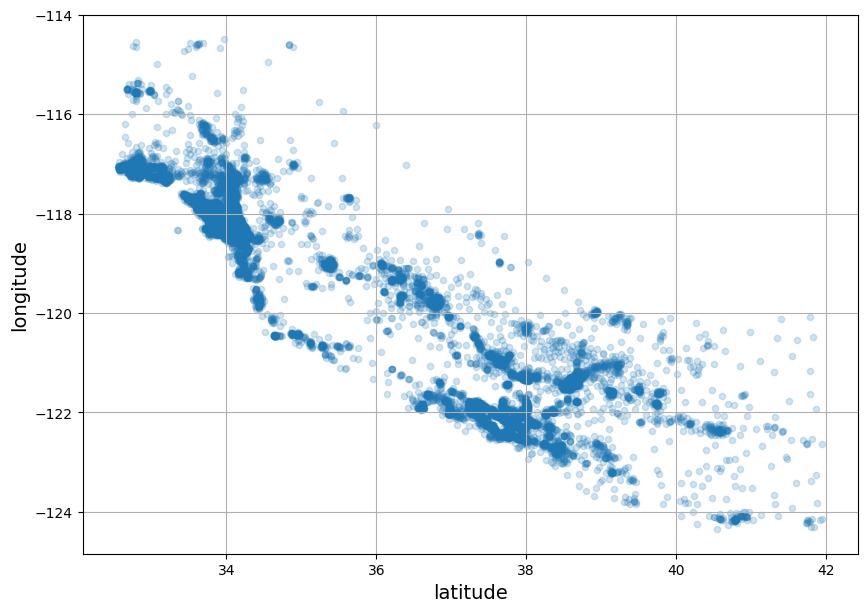

In [29]:
df_stratified.plot(kind = 'scatter', x='latitude', y='longitude', grid = True, alpha = 0.2, figsize= (10,7))
plt.show()

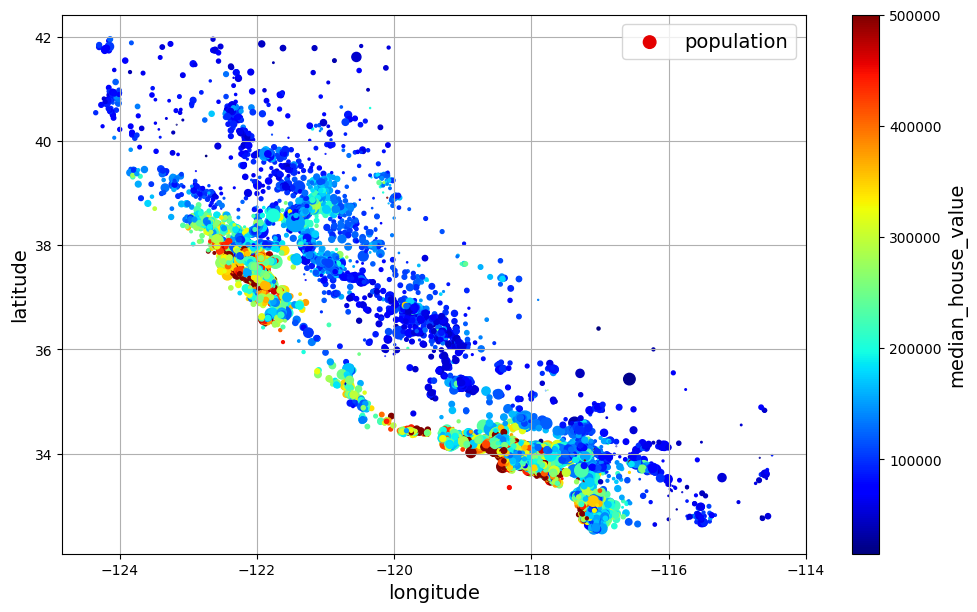

In [30]:
df_stratified.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df_stratified["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(12, 7))
plt.show()

In [31]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

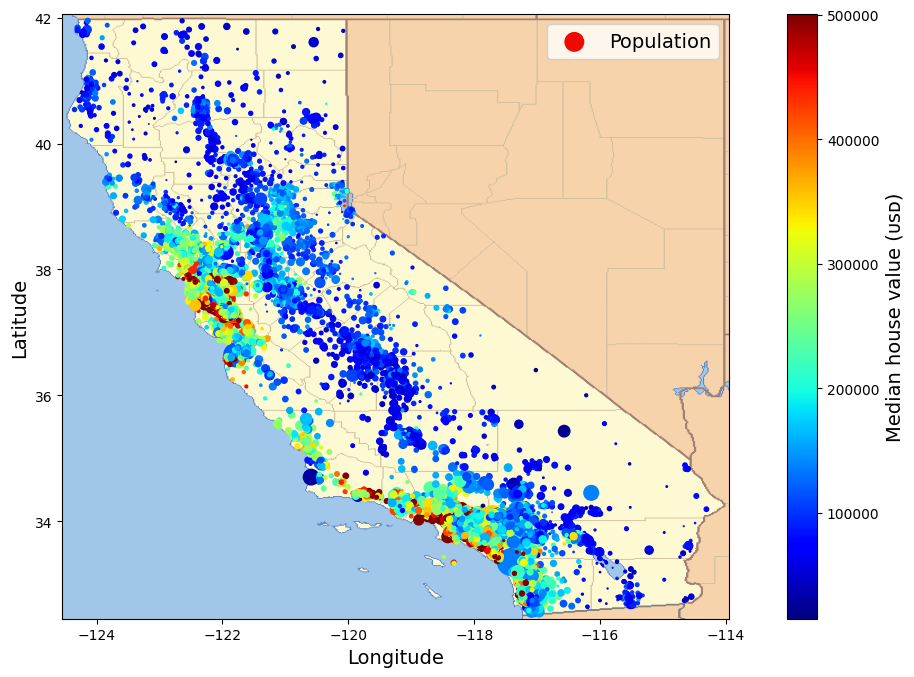

In [32]:
housing_renamed = df.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(12, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Correlation

In [33]:
corr_matrix = df_stratified.corr(numeric_only=True)

In [34]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

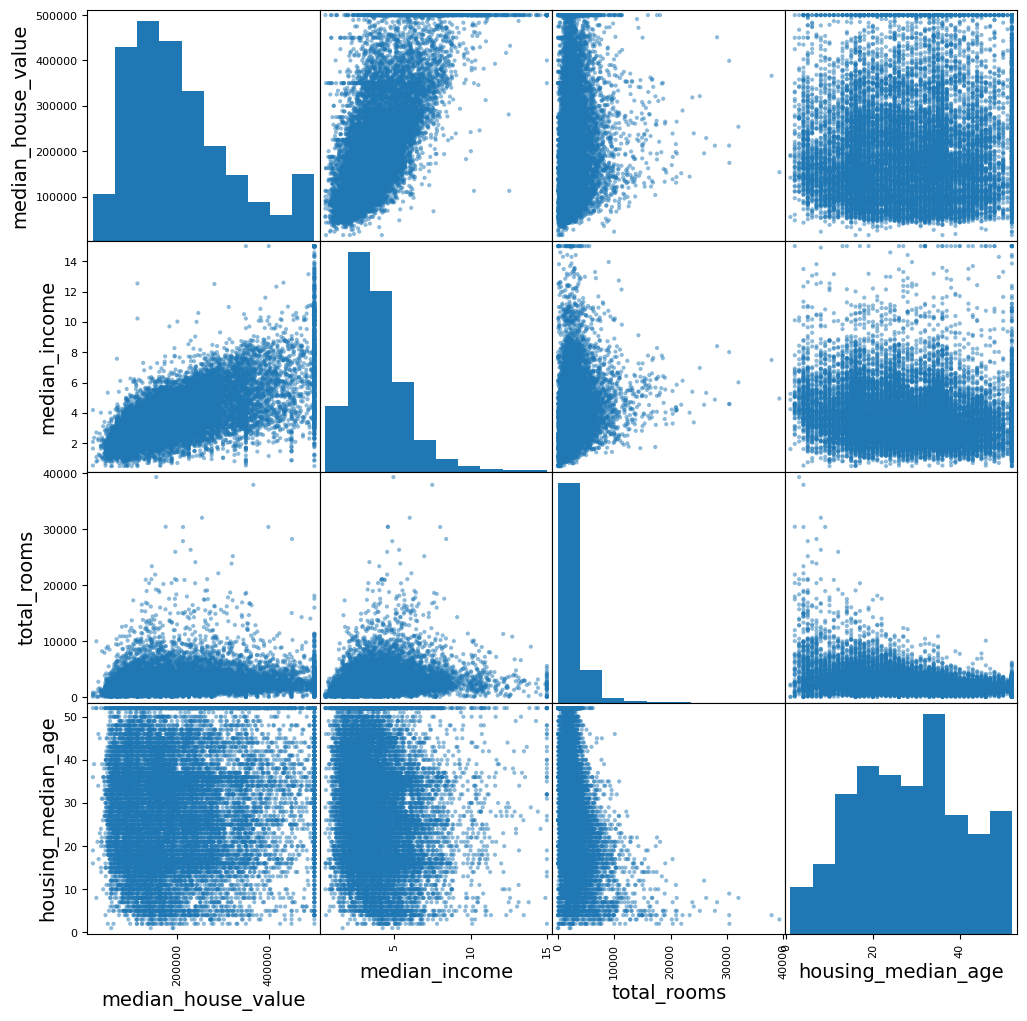

In [35]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(df_stratified[attributes], figsize=(12, 12))
# save_fig("scatter_matrix_plot")  # extra code
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

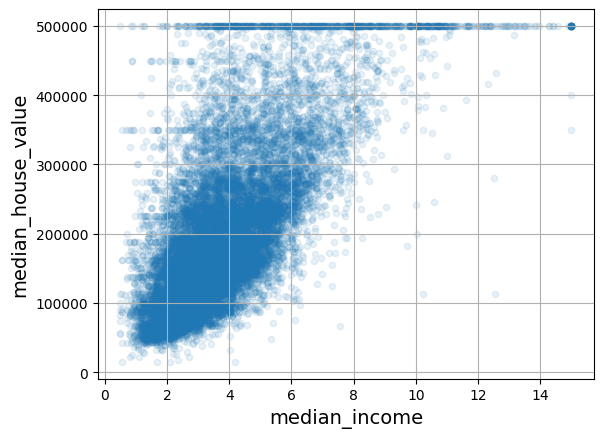

In [36]:
df_stratified.plot(kind='scatter', x= 'median_income', y='median_house_value', alpha= 0.1, grid = True)

<Axes: xlabel='median_house_value', ylabel='housing_median_age'>

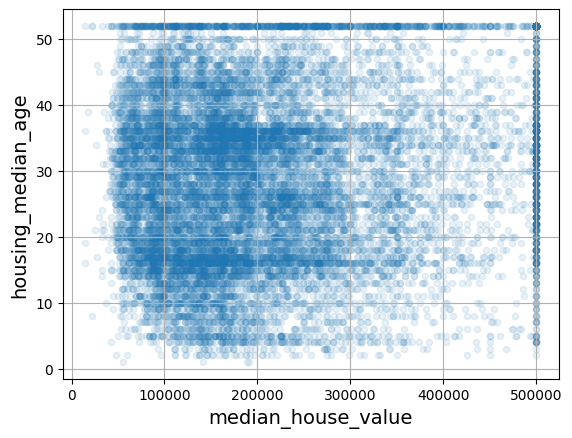

In [37]:
df_stratified.plot(kind='scatter', y= 'housing_median_age', x='median_house_value', alpha= 0.1, grid = True)

# Experimenting with Attribute Combination

In [38]:
def compare_df(data1, data2):

    df = pd.DataFrame({
        f'{data1.name}_base' : data1,
        f'{data2.name}_revised' : data2
    })

    return df
    


In [39]:
df_stratified['rooms_per_house'] = df_stratified['total_rooms'] / df_stratified['households']
df_stratified['bedroom_ratio'] = df['total_bedrooms'] / df_stratified['total_rooms']
df_stratified['people_per_house'] = df['population'] / df_stratified['households']

In [40]:
corr_matrix_revised = df_stratified.corr(numeric_only=True)

In [41]:
type(corr_matrix_revised['median_house_value'])

pandas.core.series.Series

In [42]:
pd.DataFrame({
    'Corr Revised': corr_matrix_revised['median_house_value'],
    'Corr Base': corr_matrix['median_house_value']}).sort_values('Corr Revised', ascending = False)

,Corr Revised,Corr Base
median_house_value,1.000000,1.000000
median_income,0.688380,0.688380
rooms_per_house,0.143663,NaN
total_rooms,0.137455,0.137455
housing_median_age,0.102175,0.102175
households,0.071426,0.071426
total_bedrooms,0.054635,0.054635
population,-0.020153,-0.020153
people_per_house,-0.038224,NaN
longitude,-0.050859,-0.050859


In [43]:
compare_df(corr_matrix['median_house_value'], corr_matrix_revised['median_house_value'])

,median_house_value_base,median_house_value_revised
bedroom_ratio,NaN,-0.256397
households,0.071426,0.071426
housing_median_age,0.102175,0.102175
latitude,-0.139584,-0.139584
longitude,-0.050859,-0.050859
median_house_value,1.000000,1.000000
median_income,0.688380,0.688380
people_per_house,NaN,-0.038224
population,-0.020153,-0.020153
rooms_per_house,NaN,0.143663


In [44]:
compare_df(corr_matrix['total_rooms'], corr_matrix_revised['total_rooms'])

,total_rooms_base,total_rooms_revised
bedroom_ratio,NaN,-0.183273
households,0.916143,0.916143
housing_median_age,-0.361710,-0.361710
latitude,-0.036753,-0.036753
longitude,0.044558,0.044558
median_house_value,0.137455,0.137455
median_income,0.197720,0.197720
people_per_house,NaN,-0.037702
population,0.863967,0.863967
rooms_per_house,NaN,0.128631


In [45]:
scatter_matrix_cols = [ 'median_house_value', 'bedroom_ratio', ]

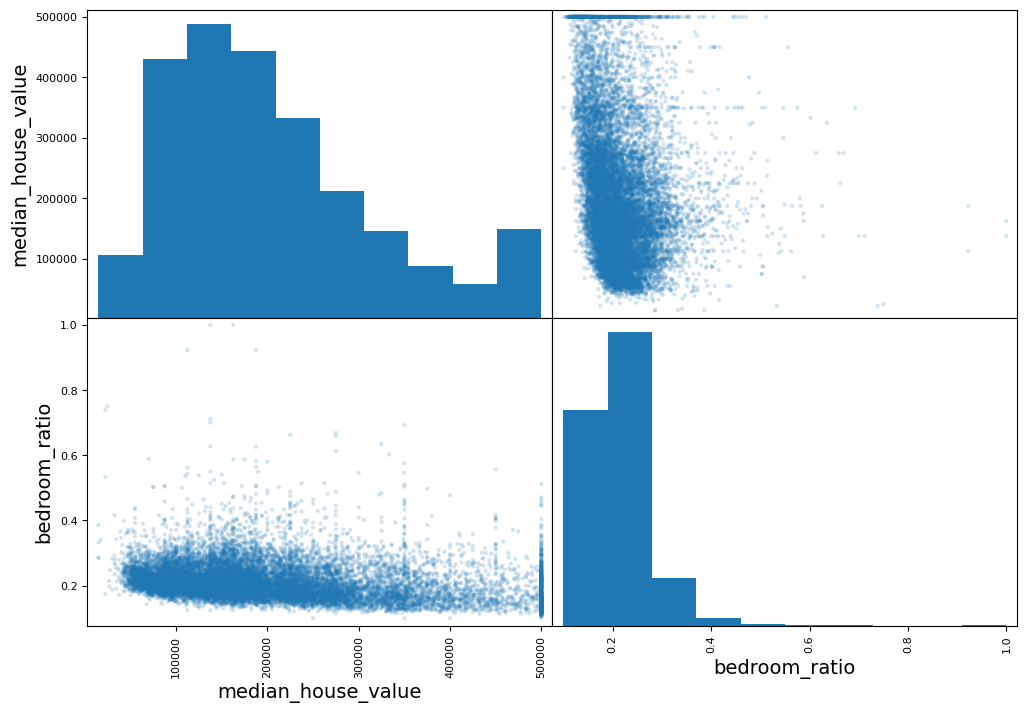

In [46]:
scatter_matrix(df_stratified[scatter_matrix_cols], alpha=0.2, figsize=(12, 8))
plt.show()

# Data Imputation

In [47]:
null_col_idx = df_stratified.isnull().any(axis = 1)

In [48]:
# bed_room_median = df_stratified['total_bedrooms'].median()

In [49]:
# df_stratified['total_bedrooms'] = df_stratified['total_bedrooms'].fillna(bed_room_median)

In [50]:
df_stratified.loc[null_col_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_house,bedroom_ratio,people_per_house
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,85900.0,INLAND,3.0,5.923503,NaN,2.774945
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,150400.0,<1H OCEAN,3.0,5.193548,NaN,4.354839
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,161200.0,<1H OCEAN,3.0,5.245136,NaN,4.272374
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,4.5,6.367713,NaN,2.542601
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,500001.0,<1H OCEAN,6.0,6.918033,NaN,2.049180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,146500.0,<1H OCEAN,3.0,5.826196,NaN,2.403023
366,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,271800.0,NEAR OCEAN,3.0,5.138418,NaN,3.211864
18241,-121.44,38.54,39.0,2855.0,NaN,1217.0,562.0,3.2404,93600.0,INLAND,3.0,5.080071,NaN,2.165480
18493,-116.21,33.75,22.0,894.0,NaN,830.0,202.0,3.0673,68200.0,INLAND,3.0,4.425743,NaN,4.108911


In [51]:
from sklearn.impute import SimpleImputer

In [52]:
imputer = SimpleImputer(strategy='median')

In [53]:
df_stratified = df_stratified.select_dtypes(np.number)

In [54]:
imputer.fit(df_stratified)

SimpleImputer(strategy='median')

In [55]:
imputer.statistics_

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        1.79200000e+05,  5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

In [56]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_house', 'bedroom_ratio',
       'people_per_house'], dtype=object)

In [57]:
X = imputer.transform(df_stratified)

In [58]:
df_imputed = pd.DataFrame(data=X,  columns=df_stratified.columns, index=df_stratified.index)

In [59]:
df_imputed.loc[null_col_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedroom_ratio,people_per_house
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,85900.0,5.923503,0.203106,2.774945
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,150400.0,5.193548,0.203106,4.354839
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,161200.0,5.245136,0.203106,4.272374
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,410700.0,6.367713,0.203106,2.542601
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,500001.0,6.918033,0.203106,2.049180
...,...,...,...,...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,434.0,954.0,397.0,3.7813,146500.0,5.826196,0.203106,2.403023
366,-122.50,37.75,44.0,1819.0,434.0,1137.0,354.0,3.4919,271800.0,5.138418,0.203106,3.211864
18241,-121.44,38.54,39.0,2855.0,434.0,1217.0,562.0,3.2404,93600.0,5.080071,0.203106,2.165480
18493,-116.21,33.75,22.0,894.0,434.0,830.0,202.0,3.0673,68200.0,4.425743,0.203106,4.108911


In [60]:
df_stratified.loc[null_col_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedroom_ratio,people_per_house
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,85900.0,5.923503,NaN,2.774945
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,150400.0,5.193548,NaN,4.354839
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,161200.0,5.245136,NaN,4.272374
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,6.367713,NaN,2.542601
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,500001.0,6.918033,NaN,2.049180
...,...,...,...,...,...,...,...,...,...,...,...,...
2348,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,146500.0,5.826196,NaN,2.403023
366,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,271800.0,5.138418,NaN,3.211864
18241,-121.44,38.54,39.0,2855.0,NaN,1217.0,562.0,3.2404,93600.0,5.080071,NaN,2.165480
18493,-116.21,33.75,22.0,894.0,NaN,830.0,202.0,3.0673,68200.0,4.425743,NaN,4.108911


## Outlier Detection

This needs further refinement and improvement

In [61]:
cols = df_stratified.columns[2:]

In [62]:
from sklearn import set_config

set_config(transform_output="pandas")

In [63]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit(X)

In [64]:
outlier_pred = isolation_forest.predict(X)

In [65]:
outlier_pred

array([-1,  1,  1, ...,  1,  1, -1])

In [66]:
df_outlier = pd.DataFrame(data=X,  columns=df_stratified.columns, index=df_stratified.index)

In [67]:
df_outlier['outlier_predict'] = outlier_pred

In [68]:
df_outlier.outlier_predict.value_counts()

outlier_predict
 1    14948
-1     1564
Name: count, dtype: int64

## Handling Categorical Data